# My First World Machine

[![Open in Colab](https://img.shields.io/badge/Open%20in%20Colab-F9AB00?style=for-the-badge&logo=googlecolab&color=525252)](https://colab.research.google.com/github/H-IAAC/WorldMachine/blob/main/examples/My%20First%20World%20Machine.ipynb) [![Open in Github](https://img.shields.io/badge/Open%20in%20Github-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/H-IAAC/WorldMachine/blob/main/examples/My%20First%20World%20Machine.ipynb)

World Machine is a research project that investigates the concept and creation of computational world models.
It is also the name for the project architecture and training protocol.

In this example, we will create a World Machine and train it on an example dataset.

Let's start by importing the `world_machine` package and other required modules:

In [1]:
try:
    import world_machine
except:
    !python3 -m pip install world_machine

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import world_machine as wm

And by checking if there is an available GPU. This will speed up the example training and evaluation:

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Creating our Dataset

For this example, we will create a model that learns the behavior of a sine function and predicts its future values. We define the data, creating our time vector, and defining random phases and frequencies:

In [4]:
t = torch.linspace(0, 99, 100)
phase = torch.lerp(torch.tensor(0.0), torch.tensor(2*torch.pi), torch.rand(1000))
frequency = torch.lerp(torch.tensor(0.1), torch.tensor(1.0), torch.rand(1000))

x = frequency[:, None] * t[None, :]
x += phase[:, None]
data = torch.sin(x)

We can plot some dataset samples:


Text(0.5, 0.98, 'Data Samples')

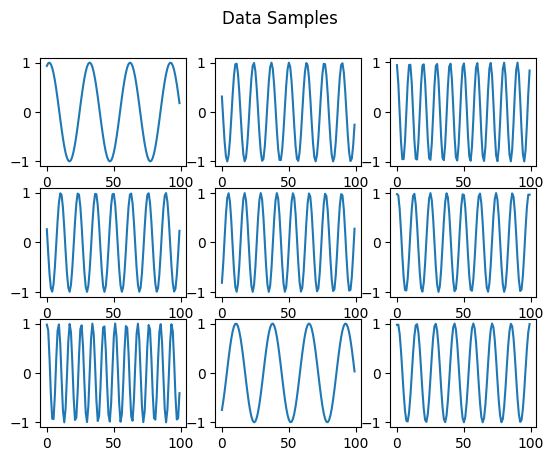

In [5]:
fig, axs = plt.subplots(3, 3)

axs_flat = axs.flatten()

for i in range(9):
    axs_flat[i].plot(data[i])

plt.suptitle("Data Samples")

To train a World Machine using our data, we need to create a `WorldMachineDataset`. It has methods for loading our data in the format the model and protocol expect. We are going to make a dataset with only one sensory channel named "data" that contains our sine signal:

In [6]:
class FirstDataset(wm.data.WorldMachineDataset):
    def __init__(self, data:torch.Tensor):
        super().__init__(sensory_channels=["data"], 
                         size=len(data))
        
        self._data = data

    def get_channel_item(self, channel, index):
        if channel == "data":
            x = self._data[index]
            y = torch.roll(self._data[index], -1)
            return x[:-1].unsqueeze(1), y[:-1].unsqueeze(1)

In [7]:
train_dataset = FirstDataset(data[:700])
val_dataset = FirstDataset(data[700:])

Then, we create dataloaders for our data:

In [8]:
batch_size = 32
dataloaders = {"train":wm.data.WorldMachineDataLoader(train_dataset, batch_size, shuffle=True, drop_last=True),
              "val":wm.data.WorldMachineDataLoader(val_dataset, batch_size, shuffle=True, drop_last=True)}

We can inspect one batch. Observe that the data is structured using PyTorch's TensorDict:

In [9]:
next(iter(dataloaders["train"]))

TensorDict(
    fields={
        index: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        inputs: TensorDict(
            fields={
                data: Tensor(shape=torch.Size([32, 99, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 99]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                data: Tensor(shape=torch.Size([32, 99, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 99]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([32]),
    device=None,
    is_shared=False)

## Model Definition

In [10]:
state_size = 32

builder = wm.WorldMachineBuilder(state_size=state_size, 
                                 max_context_size=99, 
                                 positional_encoder_type="alibi")

builder.state_activation = "tanh"

After defining the basic parameters, we need to define our sensory channels. In our case, the dataset has only one sensory channel, "data". We also define the encoders and decoders of this channel. The encoded channel will have a size of 10.

In [11]:
data_encoded_size = 10

builder.add_sensory_channel(channel_name="data", 
                            channel_size=data_encoded_size,
                            encoder=wm.layers.PointwiseFeedforward(input_dim=1, hidden_size=2*state_size, output_dim=data_encoded_size),
                            decoder=wm.layers.PointwiseFeedforward(input_dim=state_size, hidden_size=2*state_size, output_dim=1))

Then we can define our blocks. We are going to use two sensory blocks. One is conditioned on the "data" channel, and the other on the "latent world state" as it was at the start of the temporal step:

In [12]:
builder.add_block(count=1,
                  sensory_channel="data",
                  n_attention_head=2)

builder.add_block(count=1,
                  sensory_channel="state",
                  n_attention_head=2)


Finally, we can build our model:


In [13]:
model = builder.build()

## Training

The first step to training is defining our criterions. In this case, we are going to train using an MSE criterion computed on the predictions of our only "data" sensory channel:

In [14]:
cs = wm.train.CriterionSet()

cs.add_sensory_criterion(name="mse",
                         sensory_channel="data",
                         criterion=torch.nn.MSELoss(),
                         train=True)

Then, we define our training stages. They operate in callbacks during training, performing diverse operations. The first stages we are going to add are the `StateManager`, which implements the state discovery process and enables model training, and `SensoryMasker`, which allows the model to handle the absence of sensory data. Both are essential for the model:

In [15]:
stages = []

stages.append(wm.train.stages.StateManager())
stages.append(wm.train.stages.SensoryMasker(mask_percentage=wm.train.UniformScheduler(low_value=0, 
                                                                                      high_value=1, 
                                                                                      n_epoch=0)))


The following stages are `SequenceBreaker`, `ShortTimeRecaller`, and `NoiseAdder`. They perform operations that can improve the model's performance:

In [16]:
stages.append(wm.train.stages.SequenceBreaker(n_segment=2, fast_forward=True))

stages.append(wm.train.stages.ShortTimeRecaller(
    channel_sizes={"data":1},
    criterions={"data":torch.nn.MSELoss()},
    n_past=5,
    n_future=5,
    stride_past=3,
    stride_future=3
))

stages.append(wm.train.stages.NoiseAdder(
    means={"data":0.0}, 
    stds={"data":0.1}, 
    mins={"data":-1,},
    maxs={"data":1.0}
))

`EarlyStopper` saves an intermediary model at the best epoch. The final model will have the weights of this epoch. It doesn't interrupt the training.

In [17]:
stages.append(wm.train.stages.EarlyStopper())

We will use AdamW as an optimizer. We will also use Cosine Annealing with Warmup to schedule our learning rate: 

In [18]:
initial_lr = 0.002
T_mult = 1
T0 = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T0, T_mult)

stages.append(wm.train.stages.LRScheduler_Step(scheduler=scheduler))

Finally, we can create our `Trainer` with the defined criterions and stages, and train our model for 20 epochs:

In [19]:
trainer = wm.train.Trainer(criterion_set=cs, stages=stages)

In [20]:
model = model.to(device)

In [21]:
train_history = trainer(wm=model, 
                        dataloaders=dataloaders, 
                        optimizer=optimizer, 
                        n_epoch=20)

100%|██████████| 9/9 [00:00<00:00, 15.98it/s]


VAL Epoch [0/20],             Loss: 0.3791


100%|██████████| 21/21 [00:03<00:00,  5.72it/s]


Epoch [1/20],             Loss: 0.2650, Elapsed Time: 3.68 sec


100%|██████████| 9/9 [00:00<00:00, 44.05it/s]


VAL Epoch [1/20],             Loss: 0.2643


100%|██████████| 21/21 [00:01<00:00, 17.74it/s]


Epoch [2/20],             Loss: 0.2391, Elapsed Time: 1.19 sec


100%|██████████| 9/9 [00:00<00:00, 44.13it/s]


VAL Epoch [2/20],             Loss: 0.1644


100%|██████████| 21/21 [00:01<00:00, 17.16it/s]


Epoch [3/20],             Loss: 0.1699, Elapsed Time: 1.23 sec


100%|██████████| 9/9 [00:00<00:00, 44.54it/s]


VAL Epoch [3/20],             Loss: 0.1028


100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


Epoch [4/20],             Loss: 0.1534, Elapsed Time: 1.28 sec


100%|██████████| 9/9 [00:00<00:00, 41.40it/s]


VAL Epoch [4/20],             Loss: 0.1032


100%|██████████| 21/21 [00:01<00:00, 17.05it/s]


Epoch [5/20],             Loss: 0.1435, Elapsed Time: 1.24 sec


100%|██████████| 9/9 [00:00<00:00, 38.23it/s]


VAL Epoch [5/20],             Loss: 0.0870


100%|██████████| 21/21 [00:01<00:00, 17.49it/s]


Epoch [6/20],             Loss: 0.1438, Elapsed Time: 1.21 sec


100%|██████████| 9/9 [00:00<00:00, 42.00it/s]


VAL Epoch [6/20],             Loss: 0.0507


100%|██████████| 21/21 [00:01<00:00, 17.07it/s]


Epoch [7/20],             Loss: 0.1223, Elapsed Time: 1.25 sec


100%|██████████| 9/9 [00:00<00:00, 37.87it/s]


VAL Epoch [7/20],             Loss: 0.0499


100%|██████████| 21/21 [00:01<00:00, 17.52it/s]


Epoch [8/20],             Loss: 0.1155, Elapsed Time: 1.21 sec


100%|██████████| 9/9 [00:00<00:00, 39.03it/s]


VAL Epoch [8/20],             Loss: 0.0200


100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


Epoch [9/20],             Loss: 0.0986, Elapsed Time: 1.27 sec


100%|██████████| 9/9 [00:00<00:00, 44.25it/s]


VAL Epoch [9/20],             Loss: 0.0154


100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


Epoch [10/20],             Loss: 0.0823, Elapsed Time: 1.26 sec


100%|██████████| 9/9 [00:00<00:00, 43.13it/s]


VAL Epoch [10/20],             Loss: 0.0232


100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


Epoch [11/20],             Loss: 0.0756, Elapsed Time: 1.27 sec


100%|██████████| 9/9 [00:00<00:00, 45.19it/s]


VAL Epoch [11/20],             Loss: 0.0255


100%|██████████| 21/21 [00:01<00:00, 17.38it/s]


Epoch [12/20],             Loss: 0.0542, Elapsed Time: 1.22 sec


100%|██████████| 9/9 [00:00<00:00, 43.34it/s]


VAL Epoch [12/20],             Loss: 0.0122


100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


Epoch [13/20],             Loss: 0.0495, Elapsed Time: 1.27 sec


100%|██████████| 9/9 [00:00<00:00, 43.40it/s]


VAL Epoch [13/20],             Loss: 0.0097


100%|██████████| 21/21 [00:01<00:00, 18.14it/s]


Epoch [14/20],             Loss: 0.0441, Elapsed Time: 1.17 sec


100%|██████████| 9/9 [00:00<00:00, 39.84it/s]


VAL Epoch [14/20],             Loss: 0.0097


100%|██████████| 21/21 [00:01<00:00, 17.96it/s]


Epoch [15/20],             Loss: 0.0403, Elapsed Time: 1.18 sec


100%|██████████| 9/9 [00:00<00:00, 47.19it/s]


VAL Epoch [15/20],             Loss: 0.0090


100%|██████████| 21/21 [00:01<00:00, 18.79it/s]


Epoch [16/20],             Loss: 0.0390, Elapsed Time: 1.13 sec


100%|██████████| 9/9 [00:00<00:00, 46.74it/s]


VAL Epoch [16/20],             Loss: 0.0088


100%|██████████| 21/21 [00:01<00:00, 18.08it/s]


Epoch [17/20],             Loss: 0.0304, Elapsed Time: 1.17 sec


100%|██████████| 9/9 [00:00<00:00, 47.40it/s]


VAL Epoch [17/20],             Loss: 0.0104


100%|██████████| 21/21 [00:01<00:00, 18.33it/s]


Epoch [18/20],             Loss: 0.0291, Elapsed Time: 1.15 sec


100%|██████████| 9/9 [00:00<00:00, 42.70it/s]


VAL Epoch [18/20],             Loss: 0.0081


100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


Epoch [19/20],             Loss: 0.0266, Elapsed Time: 1.26 sec


100%|██████████| 9/9 [00:00<00:00, 44.56it/s]


VAL Epoch [19/20],             Loss: 0.0072


100%|██████████| 21/21 [00:01<00:00, 17.83it/s]


Epoch [20/20],             Loss: 0.0270, Elapsed Time: 1.19 sec


100%|██████████| 9/9 [00:00<00:00, 39.71it/s]

VAL Epoch [20/20],             Loss: 0.0079


We can see the training loss during training:

Text(0.5, 1.0, 'Train History')

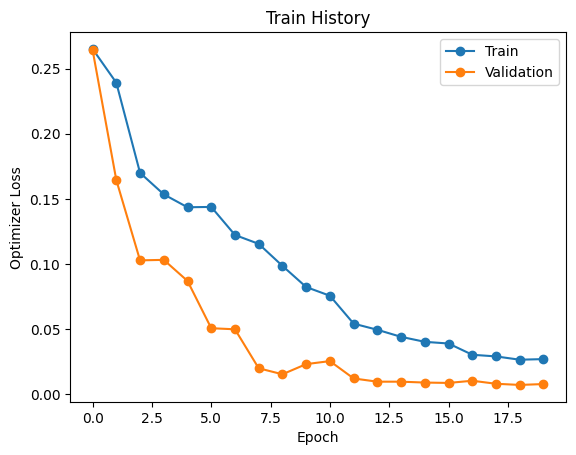

In [22]:
plt.plot(train_history["optimizer_loss_train"], "o-", label="Train")
plt.plot(train_history["optimizer_loss_val"], "o-", label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Optimizer Loss")

plt.legend()


plt.title("Train History")

Finally, let's ensure that only the intermediary model is deleted. In a typical script (not a Jupyter Notebook), this is not necessary:

In [ ]:
wm.train.stages.EarlyStopper._delete_files()

And also ensure that the states used during training are also deleted (again, only because we are running in a Jupyter Notebook):

In [ ]:
train_dataset.clear_states()
val_dataset.clear_states()

## Inference

For inferencing with the model, we need to define our initial state and use the `inference` method, passing in our sensory data as well. It is the "inputs" element of the dataloader item.

In [23]:
item = next(iter(dataloaders["val"]))

In [25]:
state = torch.zeros([batch_size, 99, state_size], device=device)

output = model.inference(state=state,
                sensory_data=item["inputs"])

In [26]:
data_pred = output["data"].cpu().detach()

Text(0.5, 1.0, 'Inference sample')

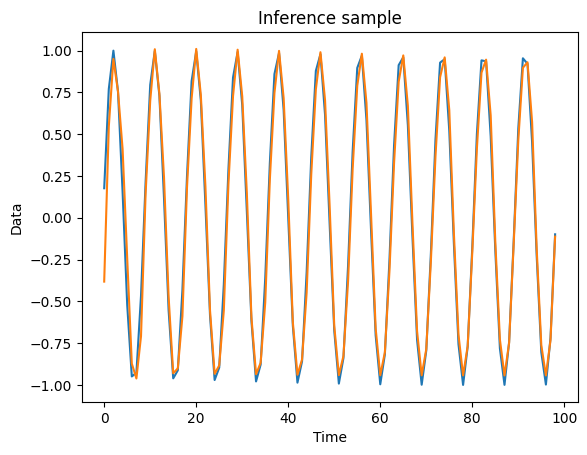

In [28]:
plt.plot(item["targets"]["data"][0])
plt.plot(data_pred[0])

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("Inference sample")

## Evaluating the model

We will evaluate our model's performance on the defined evaluation tasks. We start by creating our `MetricsGenerator` using our criterions:

In [29]:
mg = wm.evaluate.MetricsGenerator(cs)

We can then compute the model metrics:

In [30]:
metrics = mg(model, dataloaders["val"])

Metrics Generation: 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Plotting our metrics, we can see that the Prediction Shallow is one of the most challenging tasks, and Normal is the easiest:

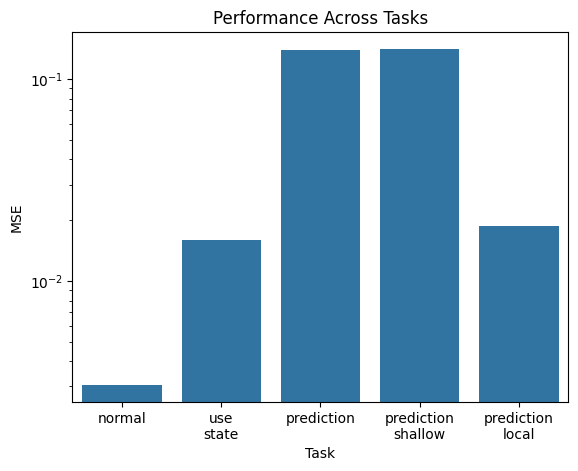

In [36]:
metrics_optimizer = {name.replace("_", "\n"):metrics[name]["optimizer_loss"] for name in metrics}

sns.barplot(metrics_optimizer)
plt.title("Performance Across Tasks")
plt.xlabel("Task")
plt.ylabel("MSE")
plt.yscale("log")

Let's also see some inference samples. For that, we are going to use a subsample of only one batch:

In [73]:
small_dataset = val_dataset
small_dataset, _ = torch.utils.data.random_split(small_dataset, [32, len(small_dataset)-32])

small_dataloader = wm.data.WorldMachineDataLoader(small_dataset, batch_size=32, shuffle=False)

In [74]:
_, logits = mg(model, small_dataloader, return_logits=True)

Metrics Generation:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


In [75]:
logits["targets"] = []

for item in small_dataloader:
    item["targets"]["state"] = torch.roll(item["inputs"]["state"], -1, 1)
    logits["targets"].append(item["targets"])
    logits["targets"]
logits["targets"] = torch.cat(logits["targets"], 0)


Observe that the performance on the Prediction Shallow tasks is not optimal. We could probably improve performance by changing the model configuration and hyperparameters.

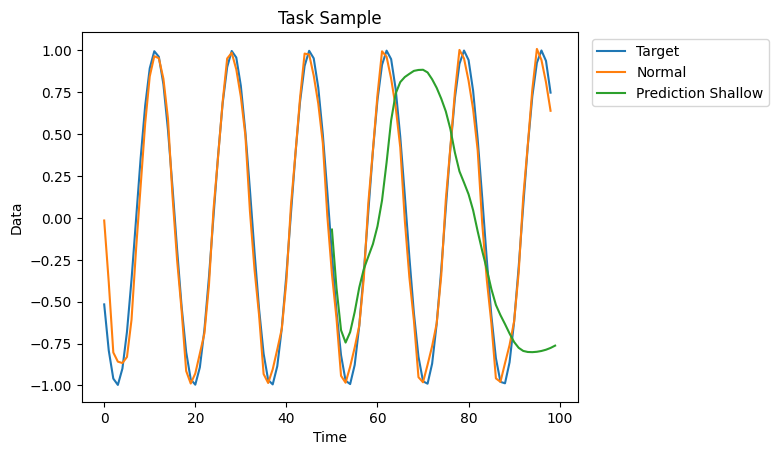

In [76]:
plt.plot(logits["targets"]["data"][i], label="Target")
plt.plot(logits["normal"]["data"][i], label="Normal")
plt.plot(range(50,100), logits["prediction_shallow"]["data"][i], label="Prediction Shallow")

plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')

plt.title("Task Sample")
plt.xlabel("Time")
plt.ylabel("Data")

plt.show()